In [1]:
import sys
sys.path.append('../../..')

from olfactory_navigation import Environment
from heuristic_spiral_agent import HeuristicSpiralAgent
from olfactory_navigation.simulation import run_test

from olfactory_navigation.agents.model_based_util.pomdp import Model
from olfactory_navigation.agents.model_based_util.belief import BeliefSet
from viz import plot_trajectory_in_tank
from util import generate_results_plots, generate_results_pdf, generate_trajectories_pdf

from matplotlib import pyplot as plt
from datetime import datetime

import pandas as pd
import numpy as np
import os

In [2]:
from cupy.cuda import runtime as cuda_runtime
cuda_runtime.setDevice(3)

## Parameters

In [3]:
# Fixed variables
actual_tank_size = np.array([90,114]) # actual size: 90cm x 114cm but it is scaled by a walking speed of <multiplier>
step_dist = 1 # 1cm per step
step_dt = 0.2 # 0.2s per step - It's the min dt we computed but it's to set when we have actual values
max_time = 900 # seconds
goal_radius = 1 # cm

# Derived variables
tank_size = actual_tank_size // step_dist
max_steps = int(max_time / step_dt)

# Environment variables
space_shape = (tank_size * 2) + 1
source_position = tank_size

print(f'Tank size: {tank_size.tolist()}; Space shape {space_shape.tolist()}; States count: {space_shape.prod()}')
print(f'{max_steps=}')

Tank size: [90, 114]; Space shape [181, 229]; States count: 41449
max_steps=4500


In [4]:
spiral_width = 4

In [5]:
# Folder variables
experiment_data_file = f'/storage/arnaud/datasets/2024_11_22_sea_robins_experimental_data/experimental_positions.csv'
test_result_folder = f'/storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_{spiral_width}-{datetime.now().strftime("%Y%m%d_%H%M%S")}/'

## Building POMDP Model

In [6]:
# Legs odor field
odor_field = np.zeros(space_shape)
odor_field_indices = np.array(list(np.ndindex(tuple(space_shape))))

in_odor_plume = np.sum((odor_field_indices - source_position[None,:])**2, axis=1) <= (0 ** 2)
odor_field[*odor_field_indices[in_odor_plume].T] = 1.0

In [7]:
thresholds = np.array([-np.inf,0.5,np.inf])
action_set = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])
action_labels = [
    'North',
    'East',
    'South',
    'West'
]

In [8]:
# Base Model parameters
state_count = np.prod(space_shape)

state_grid = [[f's_{x}_{y}' for x in range(space_shape[1])] for y in range(space_shape[0])]
# Modified to not include edge, just the ones inside the circle ( < instead of <=)
end_states = np.argwhere(np.fromfunction(lambda x,y: ((x-source_position[0])**2 + (y-source_position[1])**2) < goal_radius**2,
                                            shape=space_shape).ravel())[:,0].tolist()

# Counts
action_count = len(action_set)
observation_count = thresholds.shape[-1] # Thresholds minus 1; plus 1 for the goal.

# Building observation matrix
observations = np.empty((state_count, action_count, observation_count), dtype=float)

observations[:,:,1] = odor_field.ravel()[:,None] # legs
observations[:,:,0] = 1.0 - observations[:,:,1] # Nothing

# Goal observation
observations[:,:,-1] = 0.0
observations[end_states,:,:] = 0.0
observations[end_states,:,-1] = 1.0

# Assert observations sum to 1
assert np.all(np.sum(observations, axis=2) == 1.0), "Observation table malformed, something is wrong..."

# Observation labels
observation_labels = ['nothing', 'something_legs', 'goal']

# Compute reachable states
points = np.array(np.unravel_index(np.arange(np.prod(space_shape)), space_shape)).T

# For each actions compute all new grid points (using the environment.move method)
action_new_states = []
movements = action_set
for move_vector in movements:

    # Applying the movement vector
    new_points = points + move_vector

    # Wrap points
    new_points = np.where(new_points < 0, (new_points + space_shape[None,:]), new_points)
    new_points = np.where(new_points >= space_shape[None,:], (new_points - space_shape[None,:]), new_points)

    new_states = np.ravel_multi_index((new_points[:,0], new_points[:,1]), dims=space_shape)
    action_new_states.append(new_states)

# Forming it the reachable states array from the new states for each action
reachable_states = np.array(action_new_states).T[:,:,None]

# Instantiate the model object
model = Model(
    states = state_grid,
    actions = action_labels,
    observations = observation_labels,
    reachable_states = reachable_states,
    observation_table = observations,
    end_states = end_states
)

## Building environment

In [9]:
env = Environment(data_file=odor_field[None,:,:],
                  data_source_position=tank_size,
                  source_radius=goal_radius,
                  boundary_condition='wrap')

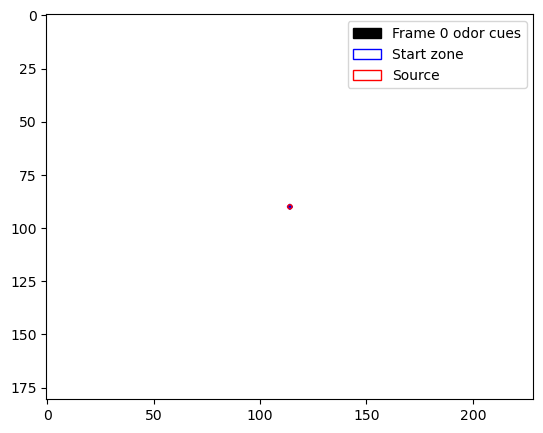

In [10]:
env.plot()

## Run test

In [11]:
ag = HeuristicSpiralAgent(env,
                          model=model,
                          spiral_step=spiral_width,
                          thresholds=thresholds.tolist())

### Experimental data

In [12]:
df = pd.read_csv(experiment_data_file)

In [13]:
exp_source_indices = df[['y_food_cm','x_food_cm']].to_numpy().astype(float)
exp_agent_indices = df[['y0_cm', 'x0_cm']].to_numpy().astype(float)

exp_source_indices /= step_dist
exp_agent_indices /= step_dist

exp_source_indices = exp_source_indices.astype(int)
exp_agent_indices = exp_agent_indices.astype(int)

In [14]:
# Generation of points
n = len(exp_source_indices)

# STATE SPACE
center_state = exp_agent_indices
agent_start_state = center_state + (tank_size[None,:] - exp_source_indices)

beliefs = []

for center, start in zip(center_state, agent_start_state):
    belief = np.zeros(space_shape)
    belief[center[0]:center[0]+tank_size[0], center[1]:center[1]+tank_size[1]] = 1
    belief /= np.sum(belief)

    beliefs.append(belief.flatten())

beliefs = np.array(beliefs)

In [15]:
all_hist = run_test(agent=ag,
                    start_points=agent_start_state,
                    environment=env,
                    # horizon=200,
                    horizon=max_steps,
                    initialization_values={'belief': BeliefSet(ag.model, beliefs)},
                    use_gpu=True,
                    print_stats=False)

Using the provided environment, not the agent environment.
[01/31/2025, 15:14:52] Sending Model to GPU...
[01/31/2025, 15:14:52]     > Done in 0.004s


  0%|          | 0/4500 [00:00<?, ?it/s]

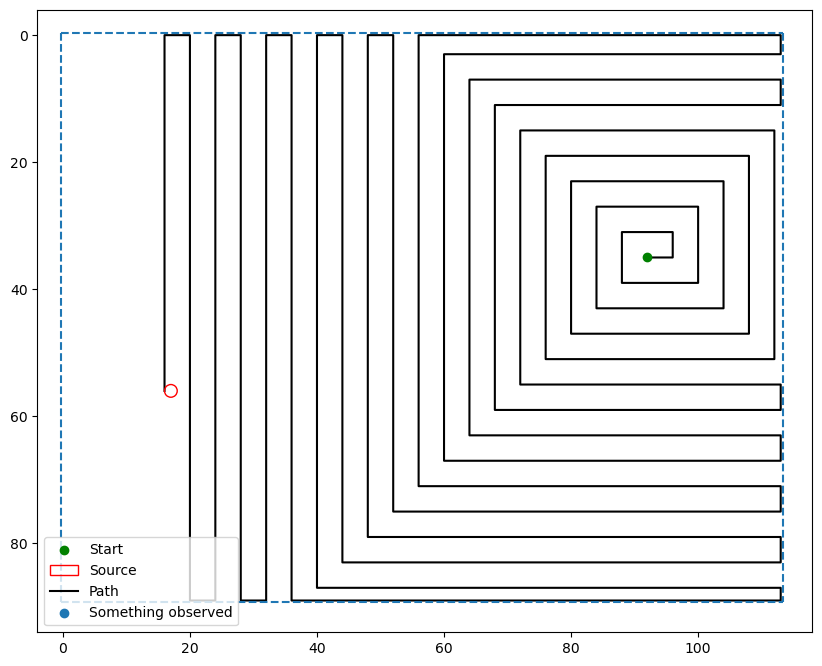

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
plot_trajectory_in_tank(h = all_hist,
                        exp_agent = exp_agent_indices,
                        exp_source = exp_source_indices,
                        t_size = tank_size,
                        traj = 47,
                        ax = ax)

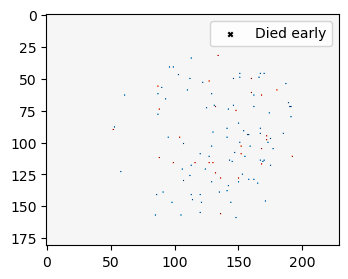

In [17]:
all_hist.plot_successes()

In [18]:
if not os.path.exists(test_result_folder):
    os.makedirs(test_result_folder)

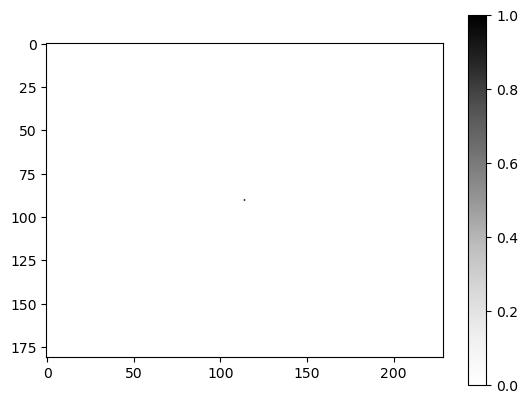

In [19]:
plt.imshow(odor_field, cmap='Greys')
plt.colorbar()
plt.savefig(test_result_folder + 'plume.png')

In [20]:
all_hist.save(folder=test_result_folder)

Simulations saved to: /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/Simulations-s_181_229-n_116-20250131_151453-horizon_4500.csv
Simulation's runs analysis saved to: /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/Simulations-s_181_229-n_116-20250131_151453-horizon_4500-runs_analysis.csv
Simulation's general analysis saved to: /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/Simulations-s_181_229-n_116-20250131_151453-horizon_4500-general_analysis.csv


In [21]:
# Computing the amount of steps out of bounds
list_steps_out_of_bounds = []

for traj in range(len(exp_agent_indices)):
    # Retrieving sim
    sim = all_hist.simulation_dfs[traj]

    # Compute shift
    start_coord = sim[['y', 'x']].to_numpy()[0]
    shift = start_coord - exp_agent_indices[traj] + 1

    # Retrieving sequence
    seq = sim[['y','x']].to_numpy() - shift[None,:]

    # Computing steps out of bounds
    steps_out_of_bounds = np.sum(np.any((seq < 0) | (seq >= tank_size), axis=1))

    # Compute the bounds for 5% and 10% of tank_size
    bounds_5_percent = tank_size * 0.05
    bounds_10_percent = tank_size * 0.10
    bounds_25_percent = tank_size * 0.25

    # Compute steps out of bounds by 5% and 10% using Manhattan distance
    steps_out_of_bounds_5_percent = np.sum(np.any((seq < -bounds_5_percent) | (seq >= tank_size + bounds_5_percent), axis=1))
    steps_out_of_bounds_10_percent = np.sum(np.any((seq < -bounds_10_percent) | (seq >= tank_size + bounds_10_percent), axis=1))
    steps_out_of_bounds_25_percent = np.sum(np.any((seq < -bounds_25_percent) | (seq >= tank_size + bounds_25_percent), axis=1))

    # Append the results to the list
    list_steps_out_of_bounds.append([steps_out_of_bounds, steps_out_of_bounds_5_percent, steps_out_of_bounds_10_percent, steps_out_of_bounds_25_percent])

array_steps_out_of_bounds = np.array(list_steps_out_of_bounds)
out_of_bounds_amount = np.sum(array_steps_out_of_bounds > 0, axis=1)

count_out_of_bounds = len(np.argwhere(array_steps_out_of_bounds[:,0]))

print(f'Simulations with steps out of bounds: {count_out_of_bounds} / {len(array_steps_out_of_bounds[:,0])}' + ('' if count_out_of_bounds == 0 else f' (avg length {np.mean(array_steps_out_of_bounds[array_steps_out_of_bounds[:,0] > 0, 0]):.2f})'))
tot = 0
for i, bound in enumerate([0, 5, 10, 25]):
    count = np.sum(out_of_bounds_amount == i)
    tot += count
    print(f'   - Inside {bound}%: {tot}')

Simulations with steps out of bounds: 29 / 116 (avg length 1605.28)
   - Inside 0%: 87
   - Inside 5%: 88
   - Inside 10%: 88
   - Inside 25%: 88


## Result Plots

In [22]:
params = {
    'tank_size': tank_size,
    'step_dt': step_dt,
    'step_dist': step_dist,
}
exp_results = {
    'new_order_exp_agent_indices': exp_agent_indices,
    'new_order_exp_source_indices': exp_source_indices,
    'out_of_bounds_amount': out_of_bounds_amount
}
generate_results_plots(test_result_folder, all_hist, params, exp_results)

## Result Pdfs

In [23]:
generate_results_pdf(test_result_folder, only_legs=True)
generate_trajectories_pdf(test_result_folder)

PDF saved as /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/results_pdfs/results_plots_all.pdf
PDF saved as /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/results_pdfs/results_plots_in_0perc_marg.pdf
PDF saved as /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/results_pdfs/results_plots_in_5perc_marg.pdf
PDF saved as /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/results_pdfs/results_plots_in_10perc_marg.pdf
PDF saved as /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/results_pdfs/results_plots_in_25perc_marg.pdf
Trajectory PDF saved as /storage/arnaud/results/sea_robins/2025_01_31-results-only_legs_spiral/results-spiral_width_4-20250131_151452/results_pdfs/trajectories.pdf
